In [1]:
import numpy as np
import pandas as pd
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [2]:
# cols_count = {}
# for col in train.drop('user_id', axis=1).columns:
#     cols_count[col] = train[col].value_counts()
# cols_count
cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 36 columns):
user_id                     1176 non-null int64
Age                         1176 non-null int64
Attrition                   1176 non-null object
BusinessTravel              1176 non-null object
DailyRate                   1176 non-null int64
Department                  1176 non-null object
DistanceFromHome            1176 non-null int64
Education                   1176 non-null int64
EducationField              1176 non-null object
EmployeeCount               1176 non-null int64
EmployeeNumber              1176 non-null int64
EnvironmentSatisfaction     1176 non-null int64
Gender                      1176 non-null object
HourlyRate                  1176 non-null int64
JobInvolvement              1176 non-null int64
JobLevel                    1176 non-null int64
JobRole                     1176 non-null object
JobSatisfaction             1176 non-null int64
MaritalStatus          

In [3]:
# 丢弃 三个没有信息的列，再对特征做映射
# train = train.drop(['user_id', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
# test = test.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
# for fea in train.drop(['user_id', 'Attrition', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1).columns:
#     train[fea] = pd.factorize(train[fea])[0]
#     test[fea] = pd.factorize(test[fea])[0]

# from sklearn.preprocessing import LabelEncoder
# lbe_list = []
# for col in cols:
#     lbe = LabelEncoder()
#     train[col] = lbe.fit_transform(train[col])
#     test[col] = lbe.transform(test[col])
#     lbe_list.append(lbe)
    

# train['Attrition'] = train['Attrition'].map(lambda x:1 if x=='Yes' else 0)

# 七个模型
import lightgbm as lgb
import xgboost as xb
import catboost as cb
import ngboost as nb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

model = {}



In [4]:
# catboost的分类
train['Attrition'] = train['Attrition'].map(lambda x:1 if x=='Yes' else 0)
train = train.drop(['user_id', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
test = test.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)

x_train, x_valid, y_train, y_valid = train_test_split(train.drop('Attrition', axis=1), train['Attrition'], test_size=0.2, random_state=42)

model['catboost'] = cb.CatBoostClassifier(iterations=1000,
                                         depth=7,
                                         learning_rate=0.01,
                                         loss_function='Logloss',
                                         eval_metric='AUC',
                                         logging_level='Verbose',
                                         metric_period=50)



# 得到分类特征的列号
categorical_features_indices = []
for i in range(len(x_train.columns)):
    if x_train.columns.values[i] in cols:
        categorical_features_indices.append(i)
print(categorical_features_indices)

model['catboost'].fit(x_train, y_train, eval_set=(x_valid, y_valid), cat_features=categorical_features_indices)

predict = model['catboost'].predict_proba(test.drop('user_id', axis=1))[:, 1]
submission = pd.DataFrame({'user_id': test['user_id'], 'Attrition': predict})
submission.to_csv("submission_cb.csv", index=False, sep=',', columns=['user_id', 'Attrition'])

[1, 3, 6, 8, 12, 14, 18, 19]
0:	test: 0.6629925	best: 0.6629925 (0)	total: 86.8ms	remaining: 1m 26s
50:	test: 0.8090145	best: 0.8090145 (50)	total: 752ms	remaining: 14s
100:	test: 0.8062862	best: 0.8090145 (50)	total: 1.34s	remaining: 11.9s
150:	test: 0.8089054	best: 0.8090145 (50)	total: 2.22s	remaining: 12.5s
200:	test: 0.8200371	best: 0.8200371 (200)	total: 2.9s	remaining: 11.6s
250:	test: 0.8232020	best: 0.8232020 (250)	total: 3.88s	remaining: 11.6s
300:	test: 0.8204736	best: 0.8232020 (250)	total: 4.76s	remaining: 11s
350:	test: 0.8179635	best: 0.8232020 (250)	total: 5.5s	remaining: 10.2s
400:	test: 0.8156717	best: 0.8232020 (250)	total: 6.23s	remaining: 9.31s
450:	test: 0.8165448	best: 0.8232020 (250)	total: 6.86s	remaining: 8.35s
500:	test: 0.8155626	best: 0.8232020 (250)	total: 7.54s	remaining: 7.5s
550:	test: 0.8153443	best: 0.8232020 (250)	total: 8.24s	remaining: 6.72s
600:	test: 0.8154535	best: 0.8232020 (250)	total: 8.93s	remaining: 5.93s
650:	test: 0.8156717	best: 0.823202

In [4]:
# GBoost分类
# 1. 使用pd.factorize方法做特征数值化  （这种方法在这个案例胜出了一点点）
# test['Attrition'] = -1
# test = test[train.columns]
# data = pd.concat([train, test])
# data = data.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
# for fea in cols:
#     data[fea] = pd.factorize(data[fea])[0]
# train = data[data['Attrition'] != -1]
# test = data[data['Attrition'] == -1]
# train['Attrition'] = train['Attrition'].map(lambda x: 1 if x=='Yes' else 0) 
# train = train.drop('user_id', axis=1)
# test = test.drop('Attrition', axis=1)

# 2.使用LabelEncoder的方法
train = train.drop(['user_id', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
test = test.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
from sklearn.preprocessing import LabelEncoder
lbe_list = []
for col in cols:
    lbe = LabelEncoder()
    train[col] = lbe.fit_transform(train[col])
    test[col] = lbe.transform(test[col])
    lbe_list.append(lbe)   

train['Attrition'] = train['Attrition'].map(lambda x:1 if x=='Yes' else 0)

from sklearn.ensemble import GradientBoostingClassifier
model['GradientBoost'] = GradientBoostingClassifier(random_state=10)
model['GradientBoost'].fit(train.drop('Attrition', axis=1), train['Attrition'])
predict = model['GradientBoost'].predict_proba(test.drop('user_id', axis=1))[:, 1]
submission = pd.DataFrame({'user_id': test['user_id'], 'Attrition': predict})
submission.to_csv("submission_gb1.csv", index=False, sep=',', columns=['user_id', 'Attrition'])

In [17]:
# lightgb分类
param = {'boosting_type':'gbdt',
                         'objective' : 'binary', #
                         #'metric' : 'binary_logloss',
                         'metric' : 'auc',
#                          'metric' : 'self_metric',
                         'learning_rate' : 0.01,
                         'max_depth' : 15,
                         'feature_fraction':0.8,
                         'bagging_fraction': 0.9,
                         'bagging_freq': 8,
                         'lambda_l1': 0.6,
                         'lambda_l2': 0,
#                          'scale_pos_weight':k,
#                         'is_unbalance':True
        }
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid)

# clf = lgb.LGBMClassifier(is_unbalanced = False, silent=False)
# cal = list(train.drop(['user_id', 'Attrition'], axis=1).columns)
# clf.fit(train.drop(['user_id', 'Attrition'],axis=1), train['Attrition'], categorical_feature=cal, verbose=5)
# predict = clf.predict_proba(test.drop(['user_id'], axis=1))[:, 1]

# submission = pd.DataFrame({'user_id': test['user_id'], 'Attrition': predict})
# submission.to_csv("submission_1.csv", index=False, sep=',', columns=['user_id', 'Attrition'])

model['lgb'] = lgb.train(param,train_data,valid_sets=[train_data,valid_data],num_boost_round = 10000 ,early_stopping_rounds=200,verbose_eval=25, categorical_feature=cols)
predict=model['lgb'].predict(test)
submission = pd.DataFrame({'user_id': test['user_id'], 'Attrition': predict})
submission.to_csv("submission_lgb.csv", index=False, sep=',', columns=['user_id', 'Attrition'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds
[25]	training's auc: 0.934439	valid_1's auc: 0.752919
[50]	training's auc: 0.947925	valid_1's auc: 0.774419
[75]	training's auc: 0.957266	valid_1's auc: 0.790462
[100]	training's auc: 0.96693	valid_1's auc: 0.797555
[125]	training's auc: 0.972795	valid_1's auc: 0.800284
[150]	training's auc: 0.978839	valid_1's auc: 0.806395
[175]	training's auc: 0.984857	valid_1's auc: 0.805195
[200]	training's auc: 0.989033	valid_1's auc: 0.807705
[225]	training's auc: 0.99224	valid_1's auc: 0.809124
[250]	training's auc: 0.994503	valid_1's auc: 0.81087
[275]	training's auc: 0.996542	valid_1's auc: 0.80956
[300]	training's auc: 0.997476	valid_1's auc: 0.814144
[325]	training's auc: 0.998464	valid_1's auc: 0.816654
[350]	training's auc: 0.998985	valid_1's auc: 0.819055
[375]	training's auc: 0.999299	valid_1's auc: 0.817309
[400]	training's auc: 0.999587	valid_1's auc: 0.817636
[425]	training's auc: 0.999686	valid_1's auc: 0.818946
[450]	trai

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[-5.62960419e+01  5.47271668e+01  1.52545622e+00 -9.86523349e+00
 -5.09852432e+00  1.49203390e+01  5.47098436e+01 -3.15689901e+01
  1.20367775e+01 -4.19090776e+01 -1.91573267e+01  2.58453544e+01
 -1.19479681e+01  1.19045492e+01 -2.81114846e+01  5.99880236e+01
  8.43991511e+01 -6.21750609e+01 -6.85682036e+01 -9.83062388e+01
  1.40610745e+01 -1.33068019e+00  1.00000000e+02 -3.75158654e+01
 -1.79583955e+01  5.54308420e+01 -4.34188559e-02 -5.84476817e+01
  5.84042628e+01]


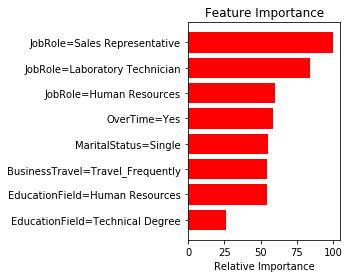

In [12]:
# logistic回归
test['Attrition'] = -1
test = test[train.columns]
data = pd.concat([train, test])
data = data.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)
for fea in cols:
    data[fea] = pd.factorize(data[fea])[0]
train = data[data['Attrition'] != -1]
test = data[data['Attrition'] == -1]
train['Attrition'] = train['Attrition'].map(lambda x: 1 if x=='Yes' else 0) 
train = train.drop('user_id', axis=1)
test = test.drop('Attrition', axis=1)

from sklearn.feature_extraction import DictVectorizer

train_features = train[cols]
# 特征向量化，不产生稀疏矩阵
dvec=DictVectorizer(sparse=True)
train_features=dvec.fit_transform(train_features.to_dict(orient='record'))
print(dvec.feature_names_)
import matplotlib.pyplot as plt
%matplotlib inline
def show_feature_importance(feature_list, feature_importance):
    # 设定阈值
    fi_threshold = 20
    # 重要特征的下标
    important_idx = np.where(feature_importance > fi_threshold)[0]
    # 特征名称
    important_features = [feature_list[i] for i in important_idx]
    # 重要特征
    sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
    # 可视化
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.subplot(1, 2, 2)
    plt.title('Feature Importance')
    plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], color='r',align='center')
    plt.yticks(pos, [important_features[i] for i in sorted_idx[::-1]])
    plt.xlabel('Relative Importance')
    plt.draw()
    plt.show()

# 采用LR模型
model = LogisticRegression(max_iter=100, verbose=True, random_state=33, tol=1e-4)
model.fit(train_features, train['Attrition'])

# 获取特征重要性
feature_importance = coef = model.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
#feature_importance = -100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
# 重要特征可视化
show_feature_importance(dvec.feature_names_, feature_importance)

# model['lr'] = LogisticRegression(verbose=1, 
#                            random_state=33,
#                            tol=1e-4
#                           )

# model['lr'].fit(train.drop('Attrition', axis=1), train['Attrition'])
# predict = model['lr'].predict_proba(test.drop('user_id', axis=1))[:, 1]
# submission = pd.DataFrame({'user_id': test['user_id'], 'Attrition': predict})
# submission.to_csv("submission_lr.csv", index=False, sep=',', columns=['user_id', 'Attrition'])

In [5]:
x_train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')